In [1]:
base_path = '/tf/PatchCL-MedSeg-jiyu'
dataset_path = '/tf/dataset/0_data_dataset_voc_950_kidney'
output_dir = '/tf/PatchCL-MedSeg/dataset/splits/kidney'

voc_mask_color_map = [
    [0, 0, 0], #_background
    [128, 0, 0] #kidney
]

In [2]:
import os
import sys
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import math
import time
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

sys.path.append(base_path)

from utils.transform import Transform
from utils.stochastic_approx import StochasticApprox
from utils.model import Network
# from utils.datasets import LabData,UnlabData
from utils.datasets_PASCAL import PascalVOCDataset
from utils.queues import Embedding_Queues
from utils.CELOSS import CE_loss
from utils.patch_utils import _get_patches
from utils.aug_utils import batch_augment
from utils.get_embds import get_embeddings
from utils.const_reg import consistency_cost
from utils.plg_loss import PCGJCL
from utils.torch_poly_lr_decay import PolynomialLRDecay

In [3]:
contrastive_batch_size = 128
img_size = 256
batch_size = 8
num_classes = 4
transform = Transform(img_size, num_classes)
embd_queues = Embedding_Queues(num_classes)
stochastic_approx = StochasticApprox(num_classes,0.5,0.8)
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = Network()
teacher_model = Network()

#Turning off gradients for teacher model
for param in teacher_model.parameters():
    param.requires_grad=False
    #Esuring mothe the models have same weight
teacher_model.load_state_dict(model.state_dict())
model.contrast=False
teacher_model.contrast = False

model = nn.DataParallel(model)
model = model.to(dev)
teacher_model = nn.DataParallel(teacher_model)
teacher_model=teacher_model.to(dev)

In [5]:
cross_entropy_loss=CE_loss(num_classes, image_size=img_size)
metrics=[smp.utils.metrics.IoU(threshold=0.5)]

optimizer_pretrain=torch.optim.Adam(model.parameters(),lr=0.001)
optimizer_ssl=torch.optim.SGD(model.parameters(),lr=0.007)
scheduler = PolynomialLRDecay(optimizer=optimizer_pretrain, max_decay_steps=200, end_learning_rate=0.0001, power=2.0)

In [6]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [12]:
labeled_dataset = PascalVOCDataset(txt_file=output_dir + "/1-3/labeled.txt", image_size=img_size, root_dir=dataset_path, transform=data_transforms, labeled=True)
unlabeled_dataset = PascalVOCDataset(txt_file=output_dir + "/1-3/unlabeled.txt", image_size=img_size, root_dir=dataset_path, transform=data_transforms, labeled=False)
val_dataset = PascalVOCDataset(txt_file=output_dir + "/val.txt", image_size=img_size, root_dir=dataset_path, transform=data_transforms, labeled=True)

labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print('number of labeled_dataset: ', len(labeled_dataset))
print('number of unlabeled_dataset: ', len(unlabeled_dataset))
print('number of val_dataset: ', len(val_dataset))

number of labeled_dataset:  285
number of unlabeled_dataset:  570
number of val_dataset:  95


torch.Size([8, 256, 256, 3]) torch.Size([8, 256, 256, 3])


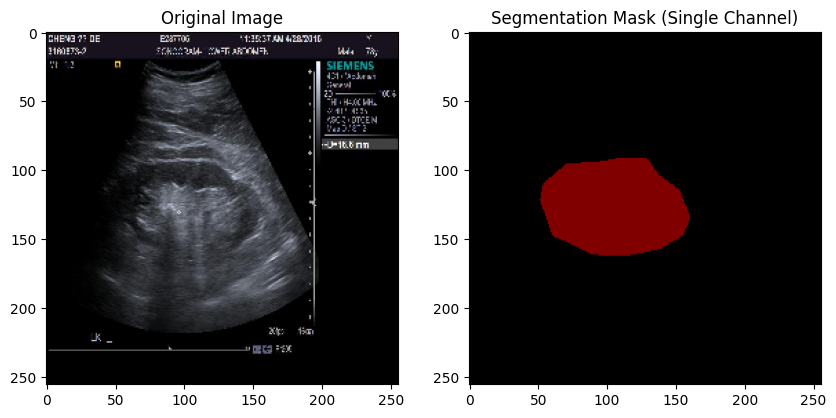

通道數:  3
通道 1 的唯一值: [  0 128]
通道 2 的唯一值: [0]
通道 3 的唯一值: [0]


In [13]:
# 測試數據加載器
for images, masks in labeled_loader:
    print(images.shape, masks.shape)
    break

# 顯示原圖和紅色通道的影像
plt.figure(figsize=(10, 5))
# 左邊顯示原圖
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.title("Original Image")

# 右邊顯示紅色通道的影像
plt.subplot(1, 2, 2)
plt.imshow(masks[0])
plt.title("Segmentation Mask (Single Channel)")
plt.show()

mask_num_channels = masks[0].shape[-1]
print('通道數: ', mask_num_channels)

for channel_idx in range(mask_num_channels):
    channel_mask = masks[0][:, :, channel_idx]
    unique_values = np.unique(channel_mask)
    print(f"通道 {channel_idx+1} 的唯一值:", unique_values)

encode_map shape:  (256, 256)
encode_map 內像素分佈:  [0 1]


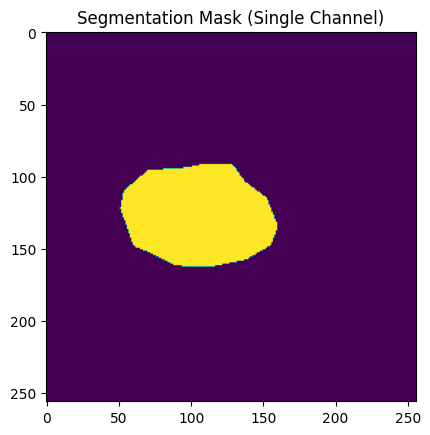

In [11]:
from dataloaders.utils import encode_segmap
np_mask = masks[0].numpy()
encode_map = encode_segmap(np_mask, voc_mask_color_map)

print("encode_map shape: ", encode_map.shape)

unique_values = np.unique(encode_map)
print("encode_map 內像素分佈: ", unique_values)

plt.imshow(encode_map)
plt.title("Segmentation Mask (Single Channel)")
plt.show()

In [14]:
#Send psudo masks & imgs to cpu
p_masks= masks
imgs = images

#get classwise patch list
patch_list = _get_patches(imgs, p_masks,classes=num_classes,background=True,img_size=img_size,patch_size=contrastive_batch_size)

#stochastic approximation filtering and threshold update
#qualified_patch_list = stochastic_approx.update(patch_list)
qualified_patch_list = patch_list

#make augmentations for teacher model
augmented_patch_list = batch_augment(qualified_patch_list,contrastive_batch_size)


#convert to tensor
aug_tensor_patch_list=[]
qualified_tensor_patch_list=[]
for i in range(len(augmented_patch_list)):
    if augmented_patch_list[i] is not None:
        aug_tensor_patch_list.append(torch.tensor(augmented_patch_list[i]))
        qualified_tensor_patch_list.append(torch.tensor(qualified_patch_list[i]))
    else:
        aug_tensor_patch_list.append(None)
        qualified_tensor_patch_list.append(None)

/tf/PatchCL-MedSeg-jiyu/utils/patch_utils.py:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if sum is 0:
/tf/PatchCL-MedSeg-jiyu/utils/patch_utils.py:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif sum is 1:
/tf/PatchCL-MedSeg-jiyu/utils/patch_utils.py:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if sum is 0:
/tf/PatchCL-MedSeg-jiyu/utils/patch_utils.py:58: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif sum is 1: #change x OR y for suitable cropping
/tf/PatchCL-MedSeg-jiyu/utils/patch_utils.py:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if sum is 0:
/tf/PatchCL-MedSeg-jiyu/utils/patch_utils.py:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif sum is 1:
/tf/PatchCL-MedSeg-jiyu/utils/patch_utils.py:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if sum is 0:
/tf/PatchCL-MedSeg-jiyu/utils/patch_utils.py:58: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif sum is 1: #ch

ValueError: all input arrays must have the same shape

In [ ]:
#get embeddings of qualified patches through student model
model=model.train()
model.module.contrast=True
student_emb_list = get_embeddings(model,qualified_tensor_patch_list,True)
print('student_emb_list len: ', len(student_emb_list))


#get embeddings of augmented patches through teacher model
teacher_model.train()
teacher_model.module.contrast = True
teacher_embedding_list = get_embeddings(teacher_model,aug_tensor_patch_list,False)
print('teacher_embedding_list len: ', len(teacher_embedding_list))

#enqueue these
embd_queues.enqueue(teacher_embedding_list)

#calculate PCGJCL loss
PCGJCL_loss = PCGJCL(student_emb_list, embd_queues, 128, 0.2 , 4, psi=4096)
PCGJCL_loss = PCGJCL_loss.to(dev)
print('PCGJCL_loss: ', PCGJCL_loss)

model.module.contrast=False
#calculate supervied loss
imgs, masks =imgs.to(dev), masks.to(dev)
out = model(imgs)
print('masks shape: ', masks.shape)
print('output shape: ', out.shape)

supervised_loss = cross_entropy_loss(out,masks)
supervised_loss = supervised_loss.to(dev)

print('supervised_loss: ', supervised_loss)

#total loss
loss = supervised_loss + 0.5*PCGJCL_loss